In [42]:
import os
from dotenv import load_dotenv
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
import datetime as dt
import matplotlib.pyplot as plt
import vectorbt as vbt
import numpy as np
import pandas as pd

In [43]:
load_dotenv() # loads .env
API_KEY = os.getenv('API_KEY')
SECRET_KEY = os.getenv('SECRET_KEY')

# Connect to Alpaca Market Data API and create request
data_client = StockHistoricalDataClient(API_KEY, SECRET_KEY) # creates handshake

request_params = StockBarsRequest(
    symbol_or_symbols=["SPY"],
    timeframe=TimeFrame.Minute,
    start="2025-01-01"
) # request object - what we want

bars = data_client.get_stock_bars(request_params) # actual request
data = bars.df # request --> df
print("Successfully fetched:\n")
data.tail()



Successfully fetched:



open    high       low    close  volume  \
symbol timestamp                                                                
SPY    2026-02-05 00:55:00+00:00  687.9604  688.00  687.9600  688.000  1026.0   
       2026-02-05 00:56:00+00:00  688.1462  688.18  688.1462  688.170  1435.0   
       2026-02-05 00:57:00+00:00  688.0900  688.09  688.0900  688.090    97.0   
       2026-02-05 00:58:00+00:00  688.0100  688.03  687.9600  688.009  1170.0   
       2026-02-05 00:59:00+00:00  687.9400  687.98  687.9000  687.900   545.0   

                                  trade_count        vwap  
symbol timestamp                                           
SPY    2026-02-05 00:55:00+00:00         31.0  687.972322  
       2026-02-05 00:56:00+00:00         46.0  688.174121  
       2026-02-05 00:57:00+00:00         20.0  688.090000  
       2026-02-05 00:58:00+00:00         27.0  688.013309  
       2026-02-05 00:59:00+00:00         25.0  687.956021

In [44]:
data1 = data.copy()

In [45]:
data.index = data.index.droplevel(0)

data = data.sort_index()

# Force the index to be a proper UTC DatetimeIndex (works if it's naive OR already tz-aware)
data.index = pd.to_datetime(data.index, utc=True)

# Convert to NY time for session logic
ny = data.index.tz_convert("America/New_York")

# Regular Trading Hours (Alpaca minute bars are BAR START times, so < 16:00 is correct)
is_rth = (ny.time >= pd.to_datetime("09:30").time()) & (ny.time < pd.to_datetime("16:00").time())

# Filter to RTH
data_rth = data.loc[is_rth].copy()
ny_rth = ny[is_rth]

# Session key for daily resets
data_rth["session"] = ny_rth.normalize()


$$
\text{VWAP}_t = \frac{\sum_{i \leq t}v_ip_i}{\sum_{i \leq t}v_i},
$$

In [46]:
# IMPORTANT: do this on data_rth, not data (data may not have 'session')
data_rth["dollar_volume"] = data_rth["vwap"] * data_rth["volume"]   # $ volume per minute using bar VWAP
data_rth["cum_dollar_vol"] = data_rth.groupby("session")["dollar_volume"].cumsum()  # reset each session
data_rth["cum_vol"] = data_rth.groupby("session")["volume"].cumsum()                # reset each session

data_rth["vwap_intraday"] = (
    data_rth["cum_dollar_vol"] / data_rth["cum_vol"].replace(0, np.nan)  # avoid /0
)


$$
\sigma_t = \text{std}(d_t) = \text{std}(p_t - \text{VWAP}_t).
$$
$$
\text{Upper}_t = \text{VWAP}_t + k\sigma_t
$$
$$
\text{Lower}_t = \text{VWAP}_t - k\sigma_t.
$$

In [47]:
ROLLING_WINDOW = 20
k = 2

# deviation from intraday VWAP using CLOSE (decision price)
data_rth["d_t"] = data_rth["close"] - data_rth["vwap_intraday"]

# rolling std of deviation, reset each trading session
data_rth["sigma_d_t"] = (
    data_rth
    .groupby("session")["d_t"]
    .transform(lambda x: x.rolling(ROLLING_WINDOW, min_periods=ROLLING_WINDOW).std())
)

# VWAP bands
data_rth["upper_band"] = data_rth["vwap_intraday"] + k * data_rth["sigma_d_t"]
data_rth["lower_band"] = data_rth["vwap_intraday"] - k * data_rth["sigma_d_t"]


In [48]:
# tradable once bands exist (i.e., after rolling window warmup)
data_rth["tradable"] = data_rth["upper_band"].notna() & data_rth["lower_band"].notna()


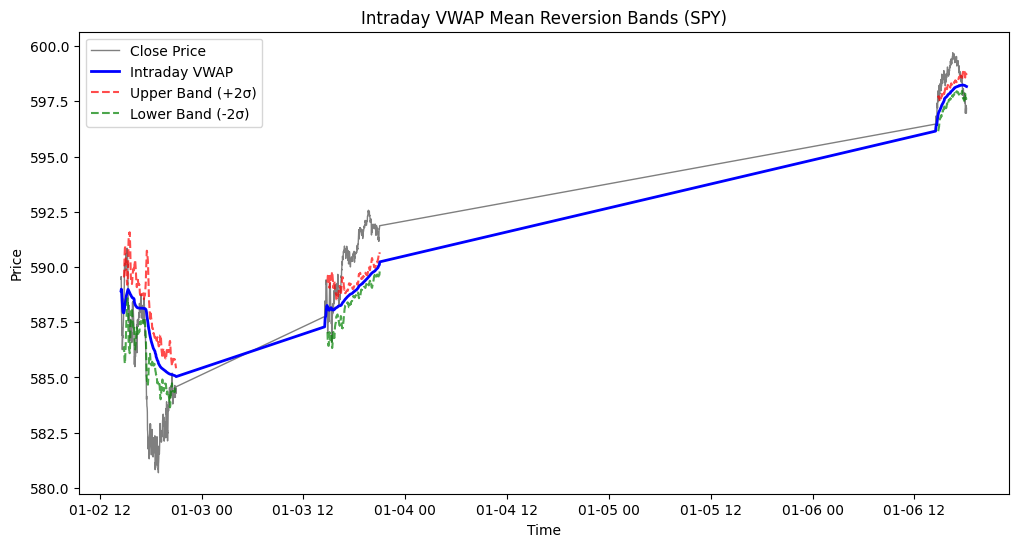

In [49]:
subset = data_rth.sort_index().iloc[:1000]  # increasing data via sort index and does first 1000 rows

# initializes plot
plt.figure(figsize=(12, 6))

# plots x vs y basically
plt.plot(subset.index, subset["close"], label="Close Price", color="black", alpha=0.5, linewidth=1)
plt.plot(subset.index, subset["vwap_intraday"], label="Intraday VWAP", color="blue", linewidth=2)
plt.plot(subset.index, subset["upper_band"], label="Upper Band (+2σ)", color="red", linestyle="--", alpha=0.7)
plt.plot(subset.index, subset["lower_band"], label="Lower Band (-2σ)", color="green", linestyle="--", alpha=0.7)

plt.title("Intraday VWAP Mean Reversion Bands (SPY)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(loc="best")
plt.show()


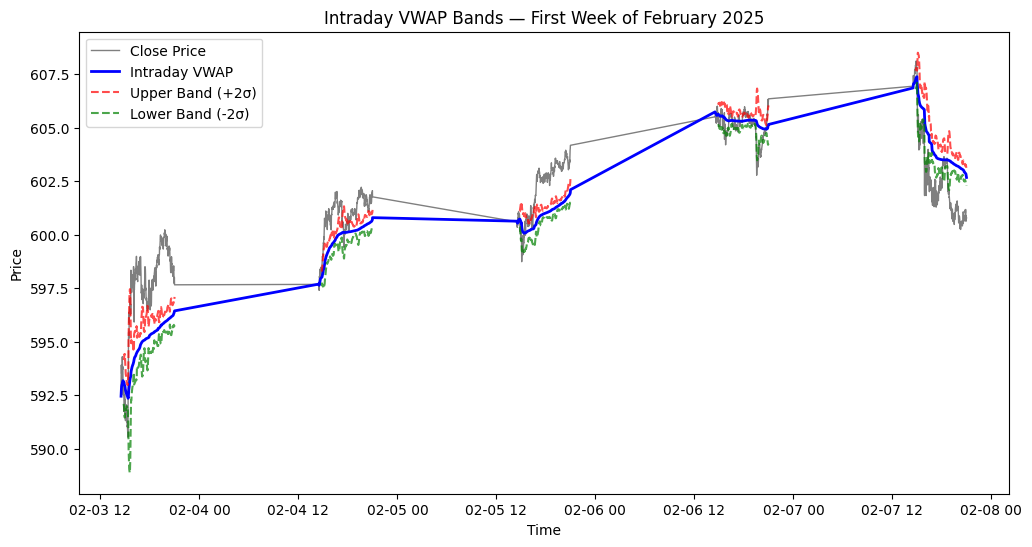

In [50]:
# first week of February 2025 (intraday, RTH-only data)
week_data = data_rth["2025-02-03":"2025-02-07"]

plt.figure(figsize=(12, 6))

plt.plot(week_data.index, week_data["close"], label="Close Price", color="black", alpha=0.5, linewidth=1)
plt.plot(week_data.index, week_data["vwap_intraday"], label="Intraday VWAP", color="blue", linewidth=2)
plt.plot(week_data.index, week_data["upper_band"], label="Upper Band (+2σ)", color="red", linestyle="--", alpha=0.7)
plt.plot(week_data.index, week_data["lower_band"], label="Lower Band (-2σ)", color="green", linestyle="--", alpha=0.7)

plt.title("Intraday VWAP Bands — First Week of February 2025")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(loc="best")

plt.show()


C:\Users\maxme\AppData\Local\Temp\ipykernel_51148\3908634583.py:12: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



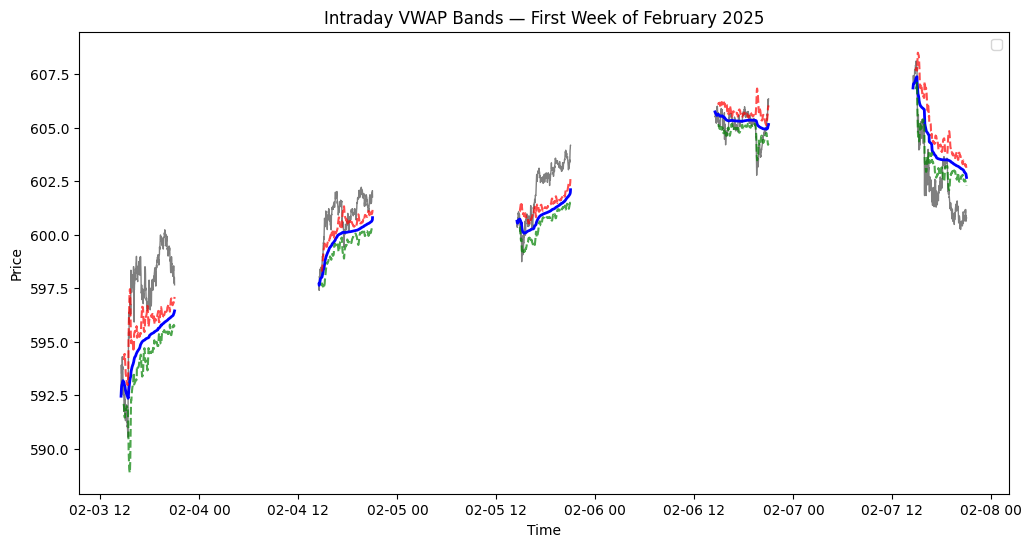

In [51]:
plt.figure(figsize=(12, 6))

for session, day_df in week_data.groupby("session"):
    plt.plot(day_df.index, day_df["close"], color="black", alpha=0.5, linewidth=1)
    plt.plot(day_df.index, day_df["vwap_intraday"], color="blue", linewidth=2)
    plt.plot(day_df.index, day_df["upper_band"], color="red", linestyle="--", alpha=0.7)
    plt.plot(day_df.index, day_df["lower_band"], color="green", linestyle="--", alpha=0.7)

plt.title("Intraday VWAP Bands — First Week of February 2025")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(loc="best")

plt.show()


This is the old trading logic! We will update this. Run to view the old strat's stats. 

In [52]:

data_rth["long_entry_signal_initial"] = data_rth["close"] < data_rth["lower_band"]
data_rth["short_entry_signal_initial"] = data_rth["close"] > data_rth["upper_band"]

data_rth["long_exit_signal_initial"] = data_rth["close"] >= data_rth["vwap_intraday"]
data_rth["short_exit_signal_initial"] = data_rth["close"] <= data_rth["vwap_intraday"]

pf = vbt.Portfolio.from_signals(
    close=data_rth["close"],
    entries=data_rth["long_entry_signal_initial"],
    exits=data_rth["long_exit_signal_initial"],
    short_entries=data_rth["short_entry_signal_initial"],
    short_exits=data_rth["short_exit_signal_initial"],
    freq="1min",
    init_cash=100_000
)

print(pf.stats())

Start                         2025-01-02 14:30:00+00:00
End                           2026-02-04 20:59:00+00:00
Period                                 73 days 21:34:00
Start Value                                    100000.0
End Value                                  84745.355771
Total Return [%]                             -15.254644
Benchmark Return [%]                          16.400034
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              23.052779
Max Drawdown Duration                  70 days 19:49:00
Total Trades                                       1175
Total Closed Trades                                1175
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  75.829787
Best Trade [%]                                  2.89844
Worst Trade [%]                               -6

## New Code Below

### Vol Filtering

$$
\ell_t = \log(p_t) - \log(p_{t-1})
$$
$$
\hat{\sigma}_{\ell,t} = \text{std}(\ell_{t-v:t})
$$
$$
\text{VolOK}_t =\{{\sigma_{min} \leq \hat{\sigma}_{\ell,t} \leq \sigma_{max}}\}.
$$

In [53]:
VOL_WINDOW = 30  # minutes

# log returns on CLOSE, session-reset
data_rth["log_return"] = data_rth.groupby("session")["close"].transform(
    lambda x: np.log(x).diff()
)

# rolling volatility, session-reset
data_rth["sigma_log"] = data_rth.groupby("session")["log_return"].transform(
    lambda x: x.rolling(VOL_WINDOW, min_periods=VOL_WINDOW).std()
)

# expanding (no-lookahead) percentile thresholds
data_rth["sigma_min"] = data_rth["sigma_log"].expanding().quantile(0.2)
data_rth["sigma_max"] = data_rth["sigma_log"].expanding().quantile(0.8)

# volatility regime filter
data_rth["vol_ok"] = (
    (data_rth["sigma_log"] >= data_rth["sigma_min"]) &
    (data_rth["sigma_log"] <= data_rth["sigma_max"])
)

data_rth["vol_ok"].value_counts(dropna=False)



vol_ok
True     56416
False    49998
Name: count, dtype: int64

$$
d_{t+1} = \phi d_t + \varepsilon_{t+1}
$$
$$
\hat{\phi} = \frac{\text{Cov}(d_t, d_{t-1})}{\text{Var}(d_{t-1})}
$$

In [54]:
# Rolling AR(1) on deviations for mean reversion filter

AR_WINDOW = 60  # minutes

# phi_hat = Cov(d_t, d_{t-1}) / Var(d_{t-1})  (OLS slope in regression d_t ~ d_{t-1})
def rolling_phi(x):
    x = x.astype(float)          # d_t
    x_lag = x.shift(1)           # d_{t-1}
    cov = x.rolling(AR_WINDOW, min_periods=AR_WINDOW).cov(x_lag)
    var = x_lag.rolling(AR_WINDOW, min_periods=AR_WINDOW).var()

    return cov / var.replace(0, np.nan)

# this just calcs phi
data_rth["phi"] = data_rth.groupby("session")["d_t"].transform(rolling_phi)


$$
h_{1/2} = \frac{\ln(1/2)}{\ln(\phi)}
$$

In [55]:
# half life calc

# half life only makes senses when 0 < phi < 1.

# initialize phi
phi = data_rth["phi"]

# put nan everywhere
data_rth["half_life"] = np.nan

# we only want half life when phi between 0,1. 
# phi <= 0 means quick oscillations and we have trouble calculating the log of it
mask = (phi > 0) & (phi < 1)  # puts true or false 

# compute half life in minutes
data_rth.loc[mask, "half_life"] = np.log(0.5) / np.log(phi.loc[mask])

# ^^^ writes half life values into col

# final regime flags
# half life exists ==> 0 < phi < 1 ==> stationary ==> mean reversion
# half life < max b/c excludes slower reversion

MAX_HALFLIFE = 15  # minutes

data_rth["mean_revert_ok"] = (
    (data_rth["phi"].abs() < 1) &
    (data_rth["half_life"].notna()) & 
    (data_rth["half_life"] <= MAX_HALFLIFE)
)




In [56]:
# just some stats to get a sense of what half life values look like

data_rth['half_life'].describe(), data_rth["mean_revert_ok"].value_counts(dropna=False)

(count     87456.000000
 mean         19.819434
 std         498.496900
 min           0.283809
 25%           4.580648
 50%           7.462847
 75%          12.801722
 max      129344.639602
 Name: half_life, dtype: float64,
 mean_revert_ok
 True     70168
 False    36246
 Name: count, dtype: int64)

$$
\Delta d_t = d_t - d_{t-1}.
$$

Here is our entry logic (we assume the regime conditions are met):

We enter long when:
$$
d_t < -k \sigma_t \text{ AND } \Delta d_t>0.
$$
Similarly, we enter short when:
$$
d_t > k \sigma_t \text{ AND } \Delta d_t<0.
$$

In [57]:
# ## Entry confirmation + execution alignment (trade next minute, no lookahead)

# d_t = (close - intraday VWAP) is already computed earlier

# how d_t is changing minute-to-minute (within the SAME session so we don't get fake jumps overnight)
data_rth["delta_d"] = data_rth.groupby("session")["d_t"].diff()

# the "price i care about" for signals (we decided close is our trading/decision price)
p = data_rth["close"]

# LONG entry:
# 1) price is below lower band
# 2) delta_d > 0 means d_t is moving back up (little "turn" confirmation)
# 3) vol_ok means vol is in our acceptable regime
# 4) mean_revert_ok means AR(1)/half-life says mean reversion is plausible
# 5) tradable means bands/sigma exist (we're past warmup)
data_rth["long_entry_signal"] = (
    (p < data_rth["lower_band"]) &
    (data_rth["delta_d"] > 0) &
    (data_rth["vol_ok"]) &
    (data_rth["mean_revert_ok"]) &
    (data_rth["tradable"])
)

# SHORT entry is the mirror image:
# 1) price above upper band 
# 2) delta_d < 0 means d_t is turning back down
# 3-5) same regime filters as long side
data_rth["short_entry_signal"] = (
    (p > data_rth["upper_band"]) &
    (data_rth["delta_d"] < 0) &
    (data_rth["vol_ok"]) &
    (data_rth["mean_revert_ok"]) &
    (data_rth["tradable"])
)

# exits: we fade back to VWAP (d_t crosses 0)
# long exits when price >= VWAP (d_t >= 0)
data_rth["long_exit_signal"] = data_rth["d_t"] >= 0

# short exits when price <= VWAP (d_t <= 0)
data_rth["short_exit_signal"] = data_rth["d_t"] <= 0


# exit at end of day (intraday only, no overnight holds) 
# last bar of each session: cumcount(ascending=False) == 0
is_last_bar = data_rth.groupby("session").cumcount(ascending=False).eq(0)

# regardless of what the signal says, we exit on the last bar so we don't carry overnight risk
data_rth.loc[is_last_bar, "long_exit_signal"] = True
data_rth.loc[is_last_bar, "short_exit_signal"] = True


# when to execute trades, shift by one so no look ahead
data_rth["long_entries_exec"]  = data_rth["long_entry_signal"].shift(1)
data_rth["long_exits_exec"]    = data_rth["long_exit_signal"].shift(1)
data_rth["short_entries_exec"] = data_rth["short_entry_signal"].shift(1)
data_rth["short_exits_exec"]   = data_rth["short_exit_signal"].shift(1)




In [58]:
close = data_rth["close"].astype(np.float64).to_numpy()

# signals: must be strict bool (np.bool_), no pd.NA, no object
long_entries  = data_rth["long_entries_exec"].to_numpy(dtype=bool)
long_exits    = data_rth["long_exits_exec"].to_numpy(dtype=bool)
short_entries = data_rth["short_entries_exec"].to_numpy(dtype=bool)
short_exits   = data_rth["short_exits_exec"].to_numpy(dtype=bool)

pf_new = vbt.Portfolio.from_signals(
    close=close,
    entries=long_entries,
    exits=long_exits,
    short_entries=short_entries,
    short_exits=short_exits,
    freq="1min",
    init_cash=100_000,
)

print(pf_new.stats())


Start                                                 0
End                                              106413
Period                                 73 days 21:34:00
Start Value                                    100000.0
End Value                                 107782.944477
Total Return [%]                               7.782944
Benchmark Return [%]                          16.400034
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               7.723482
Max Drawdown Duration                  55 days 20:08:00
Total Trades                                        613
Total Closed Trades                                 613
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  74.388254
Best Trade [%]                                 3.083903
Worst Trade [%]                               -3

Examine results

expectancy = win % * avg win - loss % * avg loss

Old vs new below (complete vibe coding below)


In [59]:
import numpy as np

def expectancy_summary_portfolio(pf):
    """Compute expectancy + basic trade diagnostics from a vectorbt Portfolio."""
    t = pf.trades
    n = int(t.count())
    if n == 0:
        return {
            "trades": 0, "win_rate": np.nan,
            "avg_win_return": np.nan, "avg_loss_return": np.nan,
            "expectancy_return_per_trade": np.nan,
            "avg_win_pnl": np.nan, "avg_loss_pnl": np.nan,
            "expectancy_pnl_per_trade": np.nan,
            "payoff_ratio": np.nan, "profit_factor": np.nan,
        }

    wr = float(t.win_rate())

    avg_win_r  = float(t.winning.returns.mean())
    avg_loss_r = float(t.losing.returns.mean())  # negative
    exp_r = wr * avg_win_r + (1 - wr) * avg_loss_r

    avg_win_p  = float(t.winning.pnl.mean())
    avg_loss_p = float(t.losing.pnl.mean())      # negative
    exp_p = wr * avg_win_p + (1 - wr) * avg_loss_p

    payoff = (avg_win_r / abs(avg_loss_r)) if avg_loss_r != 0 else np.nan
    losing_sum = float(t.losing.pnl.sum())
    profit_factor = (float(t.winning.pnl.sum()) / abs(losing_sum)) if losing_sum != 0 else np.nan

    return {
        "trades": n,
        "win_rate": wr,
        "avg_win_return": avg_win_r,
        "avg_loss_return": avg_loss_r,
        "expectancy_return_per_trade": float(exp_r),
        "avg_win_pnl": avg_win_p,
        "avg_loss_pnl": avg_loss_p,
        "expectancy_pnl_per_trade": float(exp_p),
        "payoff_ratio": float(payoff),
        "profit_factor": float(profit_factor),
    }

def expectancy_summary_trades(trades):
    """Same diagnostics, but for a vectorbt Trades object (e.g., long-only / short-only)."""
    n = int(trades.count())
    if n == 0:
        return {
            "trades": 0, "win_rate": np.nan,
            "avg_win_return": np.nan, "avg_loss_return": np.nan,
            "expectancy_return_per_trade": np.nan,
            "avg_win_pnl": np.nan, "avg_loss_pnl": np.nan,
            "expectancy_pnl_per_trade": np.nan,
            "payoff_ratio": np.nan, "profit_factor": np.nan,
        }

    wr = float(trades.win_rate())

    avg_win_r  = float(trades.winning.returns.mean())
    avg_loss_r = float(trades.losing.returns.mean())  # negative
    exp_r = wr * avg_win_r + (1 - wr) * avg_loss_r

    avg_win_p  = float(trades.winning.pnl.mean())
    avg_loss_p = float(trades.losing.pnl.mean())      # negative
    exp_p = wr * avg_win_p + (1 - wr) * avg_loss_p

    payoff = (avg_win_r / abs(avg_loss_r)) if avg_loss_r != 0 else np.nan
    losing_sum = float(trades.losing.pnl.sum())
    profit_factor = (float(trades.winning.pnl.sum()) / abs(losing_sum)) if losing_sum != 0 else np.nan

    return {
        "trades": n,
        "win_rate": wr,
        "avg_win_return": avg_win_r,
        "avg_loss_return": avg_loss_r,
        "expectancy_return_per_trade": float(exp_r),
        "avg_win_pnl": avg_win_p,
        "avg_loss_pnl": avg_loss_p,
        "expectancy_pnl_per_trade": float(exp_p),
        "payoff_ratio": float(payoff),
        "profit_factor": float(profit_factor),
    }

# ---- run diagnostics for BOTH portfolios ----
old_overall = expectancy_summary_portfolio(pf)
new_overall = expectancy_summary_portfolio(pf_new)

# long/short splits (vectorbt naming varies a bit across versions)
def get_long_short_trades(pf_obj):
    t = pf_obj.trades
    if hasattr(t, "direction_long") and hasattr(t, "direction_short"):
        return t.direction_long, t.direction_short
    if hasattr(t, "long") and hasattr(t, "short"):
        return t.long, t.short
    raise AttributeError("Could not find long/short trade subsets on pf.trades (version mismatch).")

old_long_trades, old_short_trades = get_long_short_trades(pf)
new_long_trades, new_short_trades = get_long_short_trades(pf_new)

old_long  = expectancy_summary_trades(old_long_trades)
old_short = expectancy_summary_trades(old_short_trades)
new_long  = expectancy_summary_trades(new_long_trades)
new_short = expectancy_summary_trades(new_short_trades)


In [60]:
import pandas as pd

# row order + formatting rules
order = [
    "trades",
    "win_rate",
    "avg_win_return",
    "avg_loss_return",
    "expectancy_return_per_trade",
    "payoff_ratio",
    "profit_factor",
    "avg_win_pnl",
    "avg_loss_pnl",
    "expectancy_pnl_per_trade",
]

fmt = {
    "win_rate": "{:.2%}",
    "avg_win_return": "{:.4%}",
    "avg_loss_return": "{:.4%}",
    "expectancy_return_per_trade": "{:.4%}",
    "payoff_ratio": "{:.2f}",
    "profit_factor": "{:.2f}",
    "avg_win_pnl": "${:,.0f}",
    "avg_loss_pnl": "${:,.0f}",
    "expectancy_pnl_per_trade": "${:,.2f}",
}

def format_table(dct_by_colname, title=None):
    """Build a nicely formatted comparison table from {col_name: summary_dict}."""
    df = pd.DataFrame(dct_by_colname).loc[order].copy()

    pretty = df.copy()
    for idx in pretty.index:
        for col in pretty.columns:
            val = pretty.loc[idx, col]
            if pd.isna(val):
                pretty.loc[idx, col] = ""
            elif idx in fmt:
                pretty.loc[idx, col] = fmt[idx].format(val)
            else:
                # trades should look like an int
                if idx == "trades":
                    pretty.loc[idx, col] = f"{int(val)}"
                else:
                    pretty.loc[idx, col] = f"{val}"
    if title:
        print(f"\n{title}\n" + "-" * len(title))
    return pretty

# Overall comparison
overall_tbl = format_table(
    {"Old Strategy": old_overall, "New Strategy": new_overall},
    title="Overall"
)

# Long/short breakdown comparison
ls_tbl = format_table(
    {"Old Long": old_long, "Old Short": old_short, "New Long": new_long, "New Short": new_short},
    title="Long vs Short"
)

overall_tbl, ls_tbl



Overall
-------

Long vs Short
-------------


C:\Users\maxme\AppData\Local\Temp\ipykernel_51148\3138069182.py:44: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1175' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

C:\Users\maxme\AppData\Local\Temp\ipykernel_51148\3138069182.py:44: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '613' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

C:\Users\maxme\AppData\Local\Temp\ipykernel_51148\3138069182.py:44: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '576' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

C:\Users\maxme\AppData\Local\Temp\ipykernel_51148\3138069182.py:44: FutureWarning:

Setting an item of incompatible dtyp

(                            Old Strategy New Strategy
 trades                              1175          613
 win_rate                          75.83%       74.39%
 avg_win_return                   0.1460%      0.1746%
 avg_loss_return                 -0.5144%     -0.4559%
 expectancy_return_per_trade     -0.0136%      0.0131%
 payoff_ratio                        0.28         0.38
 profit_factor                       0.88         1.11
 avg_win_pnl                         $130         $179
 avg_loss_pnl                       $-466        $-471
 expectancy_pnl_per_trade         $-13.78       $12.70,
                              Old Long Old Short  New Long New Short
 trades                            576       599       281       332
 win_rate                       77.43%    74.29%    77.58%    71.69%
 avg_win_return                0.1435%   0.1484%   0.1623%   0.1859%
 avg_loss_return              -0.5270%  -0.5036%  -0.5136%  -0.4172%
 expectancy_return_per_trade  -0.0078%  -0.0192% 

Overall, much better. Fewer trades, higher expectancy, both longs and shorts work. 

Next: Position sizing, time of day conditioning?, dynamic exits (vol adjusted, half life stop)?, add costs into vectorbt, 